# Training Schemes

In this example, we explore different optimization schemes for training deep neural networks. We use Batch Gradient Descent, Mini-Batch Gradient Descent and Stochastic Gradient Descent.


## Stage 1: Data Definition.

For this example, we use the synthetic dataset available in the [link](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html). It configures a binary classification problem.

In [1]:
# Required Libraries
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import time

# DNN libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# We define some useful functions

def plot_dataset(X, y, axes):
    plt.figure(figsize=(4, 3), dpi=160)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "b+")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "r+")
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)


def plot_predictions(X, y, model, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X_ = np.c_[x0.ravel(), x1.ravel()]
    with torch.no_grad():
      y_pred = model(torch.tensor(X_).float()).reshape(x0.shape)
    plot_dataset(X, y, axes)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.coolwarm, alpha=0.2)

We built a dataset with $300$ samples. We use the 80% for training and the remaining 20% for testing.

In [3]:
n = 300
X, y = make_moons(n_samples=n, noise=0.05, random_state=42)
train_size = int(n * 0.8)

x_train, x_test = X[:train_size,:], X[train_size:,:]
y_train, y_test = y[:train_size], y[train_size:]

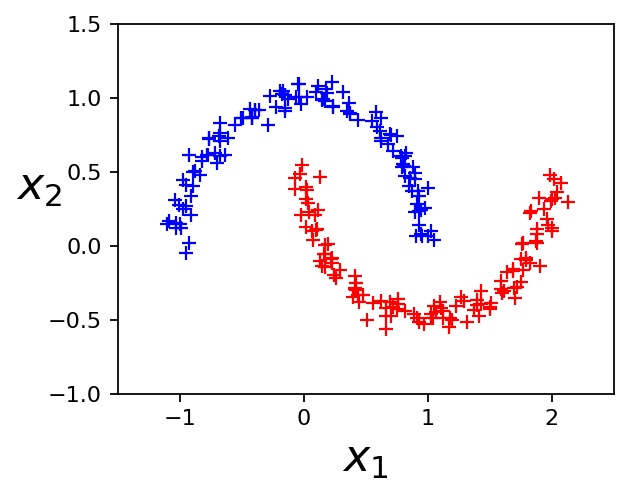

In [4]:
plot_dataset(x_train, y_train, [-1.5, 2.5, -1, 1.5])
plt.show()

In [5]:
#Defining the data containers
X_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train.reshape(-1,1)).float()
X_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test.reshape(-1,1)).float()

## Stage 2: We define the model

We write some useful functions to define and train the neural network. The training processes will be performed by three optimizers:

- Batch Gradient Descent
- Stochastic Gradient Descent
- MiniBatch Gradient Descent

In [6]:
# A class to define the DNN
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 32), # The input layer has 2 units.
            nn.ReLU(),
            nn.Linear(32, 16), # The input layer has 2 units.
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid() # This activation function maps the real values in the
                         # outputs to probabilites.
        )

    def forward(self, x):
        # This method is used to compute the output given a particular input x.
        logits = self.linear_relu_stack(x)
        return logits

# We do this to use the GPU (if we only use CPU, the training will take a lot of time)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


In [7]:
# We define a function to train the DNN model. We need to specify the batch size
def fit_model(model, train_dataloader, test_dataloader, epochs):
  learning_rate = 0.01
  loss_fn = nn.BCELoss()

  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


  loss_tr = []
  loss_te = []
  for epoch in range(epochs):
    for x, y in train_dataloader:
      # The variable should be sent to the GPU
      x = x.to(device)
      y = y.to(device)
      # Make predictions
      model.train()
      y_pred = model(x)
      # Compute the loss of current predictions
      loss = loss_fn(y_pred, y)
      # Clean the gradients
      optimizer.zero_grad()
      # Perform backpropagation
      loss.backward()
      # update weights
      optimizer.step()

    # since we're not training, we don't need to calculate the gradients for our outputs
    loss_test = 0
    with torch.no_grad():
      for data in test_dataloader:
          x, labels = data
          x = x.to(device)
          labels = labels.to(device)
          # calculate outputs by running images through the network
          outputs = model(x)
          loss_test += loss_fn(outputs, labels).item() * labels.size(0)

    # Storing the training and test losses
    loss_tr.append(loss.item())
    loss_te.append(loss_test/len(test_dataloader.dataset))
    print("epoch {} loss: {:.4f} test_loss: {:.4f}".format(epoch + 1,loss.item(),loss_test/len(test_dataloader.dataset)))

  return model, loss_tr, loss_te

In [9]:
# A function to evaluate the model
def evaluate(model, loss_tr, loss_te, test_dataloader, batch_size, epochs):
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in test_dataloader:
          x, labels = data
          x = x.to(device)
          labels = labels.to(device)
          # calculate outputs by running samples through the network
          outputs = model(x)
          # the class with the highest energy is what we choose as prediction
          predicted = torch.round(outputs.data)
          total += predicted.size(0)
          correct += (predicted[:,0] == labels[:,0]).sum().item()

  print(f'Accuracy of the network on test samples: {100 * correct // total} %')

  plt.plot(loss_tr)
  plt.plot(loss_te, 'r*')
  plt.show()

## Stage 3: Batch Gradient Descent

This first approach corresponds to batch gradient descent. In this optimization method, all available data in the training set is used. In our particular case, the training set consists of 240 samples, so we define:`batch_size = 240`.

All training data is used in each iteration, the epochs parameter used for training indicates the number of iterations.

In [10]:
# We define the hyperparameters and the loss function
batch_size = 240
epochs = 5000

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(datasets, batch_size=batch_size, shuffle=True)

datasets_test = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(datasets_test, batch_size=batch_size, shuffle=True)

In [11]:
# We build network
model_bgd = NeuralNetwork()
model_bgd.to(device) # This is to define the model in the GPU

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [12]:
start_time = time.time()
model_bgd, loss_tr, loss_te = fit_model(model_bgd, train_dataloader, test_dataloader, epochs)
print(time.time() - start_time, "seconds")

Se han truncado las últimas 5000 líneas del flujo de salida.
epoch 2 loss: 0.7250 test_loss: 0.7204
epoch 3 loss: 0.7244 test_loss: 0.7198
epoch 4 loss: 0.7238 test_loss: 0.7193
epoch 5 loss: 0.7232 test_loss: 0.7188
epoch 6 loss: 0.7227 test_loss: 0.7183
epoch 7 loss: 0.7221 test_loss: 0.7178
epoch 8 loss: 0.7215 test_loss: 0.7173
epoch 9 loss: 0.7210 test_loss: 0.7168
epoch 10 loss: 0.7204 test_loss: 0.7163
epoch 11 loss: 0.7199 test_loss: 0.7158
epoch 12 loss: 0.7193 test_loss: 0.7154
epoch 13 loss: 0.7188 test_loss: 0.7149
epoch 14 loss: 0.7183 test_loss: 0.7144
epoch 15 loss: 0.7178 test_loss: 0.7139
epoch 16 loss: 0.7172 test_loss: 0.7135
epoch 17 loss: 0.7167 test_loss: 0.7130
epoch 18 loss: 0.7162 test_loss: 0.7126
epoch 19 loss: 0.7157 test_loss: 0.7121
epoch 20 loss: 0.7152 test_loss: 0.7117
epoch 21 loss: 0.7147 test_loss: 0.7112
epoch 22 loss: 0.7142 test_loss: 0.7108
epoch 23 loss: 0.7137 test_loss: 0.7104
epoch 24 loss: 0.7132 test_loss: 0.7099
epoch 25 loss: 0.7127 test_

Accuracy of the network on test samples: 98 %


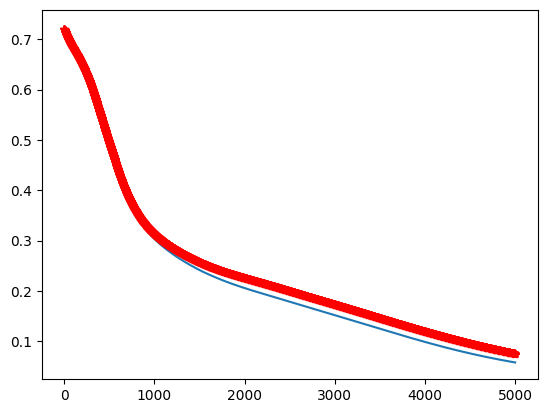

In [13]:
evaluate(model_bgd, loss_tr, loss_te, test_dataloader, batch_size, epochs)

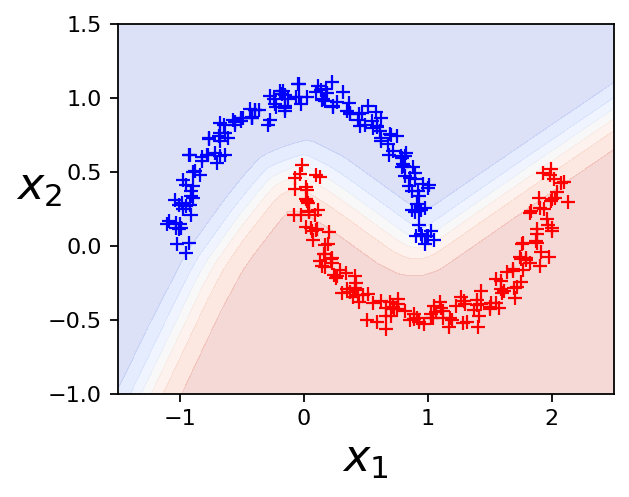

In [14]:
plot_predictions(X, y, model_bgd, [-1.5, 2.5, -1, 1.5])

## Stage 4: Stochastic Gradient Descent

In stochastic gradient descent, an epoch is considered complete when all training data has been used for optimizing the neural network. In this case, since only one sample is used in each iteration, an epoch is completed in a number of iterations equal to the size of the training set, which in this case is 240 iterations. Additionally, since the epochs parameter is set to 500, the training of the network will be carried out over 120,000 iterations.

In [15]:
batch_size = 1
epochs = 800

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(datasets, batch_size=batch_size, shuffle=True)

datasets_test = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(datasets_test, batch_size=batch_size, shuffle=True)

In [16]:
# We build network
model_sgd = NeuralNetwork()
model_sgd.to(device) # This is to define the model in the GPU

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [17]:
start_time = time.time()
model_sgd, loss_tr, loss_te = fit_model(model_sgd, train_dataloader, test_dataloader, epochs)
print(time.time() - start_time, "seconds")

epoch 1 loss: 0.6518 test_loss: 0.5566
epoch 2 loss: 0.2042 test_loss: 0.4103
epoch 3 loss: 0.1105 test_loss: 0.3267
epoch 4 loss: 0.0580 test_loss: 0.2975
epoch 5 loss: 1.1741 test_loss: 0.2709
epoch 6 loss: 0.0279 test_loss: 0.2782
epoch 7 loss: 0.0102 test_loss: 0.2508
epoch 8 loss: 0.0245 test_loss: 0.2396
epoch 9 loss: 1.9903 test_loss: 0.2354
epoch 10 loss: 1.1078 test_loss: 0.2226
epoch 11 loss: 0.0543 test_loss: 0.2185
epoch 12 loss: 0.8605 test_loss: 0.2812
epoch 13 loss: 0.0644 test_loss: 0.1994
epoch 14 loss: 0.0040 test_loss: 0.1966
epoch 15 loss: 0.1164 test_loss: 0.2262
epoch 16 loss: 0.0201 test_loss: 0.2223
epoch 17 loss: 0.0803 test_loss: 0.1529
epoch 18 loss: 0.0076 test_loss: 0.1526
epoch 19 loss: 0.0520 test_loss: 0.1312
epoch 20 loss: 0.5270 test_loss: 0.1635
epoch 21 loss: 0.0436 test_loss: 0.1103
epoch 22 loss: 0.0146 test_loss: 0.0978
epoch 23 loss: 0.0018 test_loss: 0.0919
epoch 24 loss: 0.0812 test_loss: 0.0801
epoch 25 loss: 0.0284 test_loss: 0.0725
epoch 26 

Accuracy of the network on test samples: 100 %


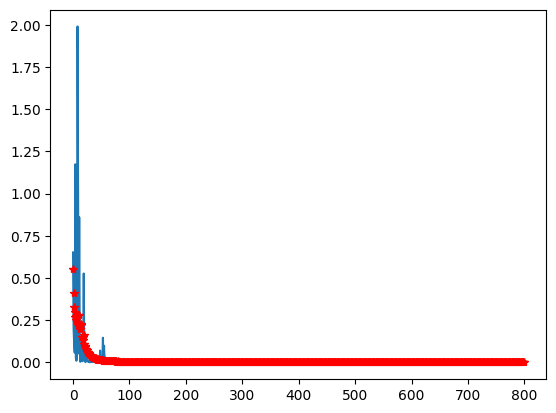

In [18]:
evaluate(model_sgd, loss_tr, loss_te, test_dataloader, batch_size, epochs)

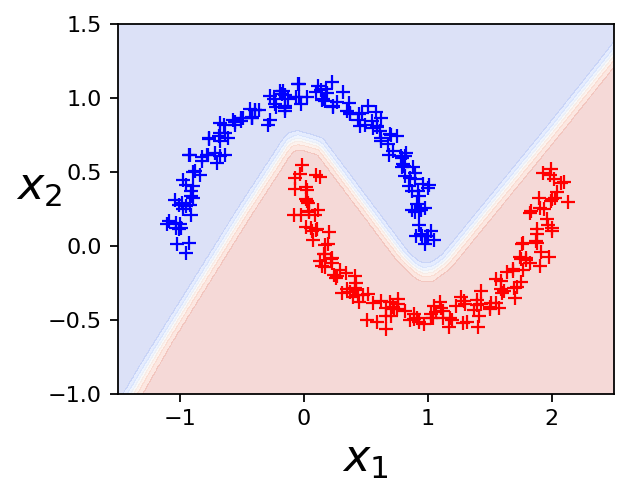

In [19]:
plot_predictions(X, y, model_sgd, [-1.5, 2.5, -1, 1.5])

## Stage 5: Mini-Batch Gradient Descent

This latter approach presents an intermediate point between stochastic optimization and batch optimization. In this mini-batch optimization scheme, the training set is randomly divided into subsets of size `batch_size`. It should be noted that the `batch_size` value is chosen by the user, thus becoming a new hyperparameter of neural networks.

Following the analysis of the previous approaches, for the mini-batch gradient descent method, an epoch is completed in $\frac{N}{batch\_size}$ iterations, where $N$ is the size of the training set. Thus, the training is carried out in $epochs*\frac{N}{batch\_size}$ iterations.

In [25]:
batch_size = 32
epochs = 5000

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(datasets, batch_size=batch_size, shuffle=True)

datasets_test = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(datasets_test, batch_size=batch_size, shuffle=True)

In [26]:
# We build network
model_mbgd = NeuralNetwork()
model_mbgd.to(device) # This is to define the model in the GPU

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [27]:
start_time = time.time()
model_mbgd, loss_tr, loss_te = fit_model(model_mbgd, train_dataloader, test_dataloader, epochs)
print(time.time() - start_time, "seconds")

Se han truncado las últimas 5000 líneas del flujo de salida.
epoch 2 loss: 0.7077 test_loss: 0.6832
epoch 3 loss: 0.6789 test_loss: 0.6783
epoch 4 loss: 0.6567 test_loss: 0.6733
epoch 5 loss: 0.6567 test_loss: 0.6685
epoch 6 loss: 0.6784 test_loss: 0.6637
epoch 7 loss: 0.6397 test_loss: 0.6588
epoch 8 loss: 0.6424 test_loss: 0.6539
epoch 9 loss: 0.6325 test_loss: 0.6489
epoch 10 loss: 0.6437 test_loss: 0.6439
epoch 11 loss: 0.6453 test_loss: 0.6388
epoch 12 loss: 0.6417 test_loss: 0.6336
epoch 13 loss: 0.6487 test_loss: 0.6284
epoch 14 loss: 0.6189 test_loss: 0.6230
epoch 15 loss: 0.6425 test_loss: 0.6176
epoch 16 loss: 0.5931 test_loss: 0.6121
epoch 17 loss: 0.6012 test_loss: 0.6065
epoch 18 loss: 0.6355 test_loss: 0.6009
epoch 19 loss: 0.6059 test_loss: 0.5952
epoch 20 loss: 0.6113 test_loss: 0.5893
epoch 21 loss: 0.5568 test_loss: 0.5832
epoch 22 loss: 0.6235 test_loss: 0.5772
epoch 23 loss: 0.6335 test_loss: 0.5711
epoch 24 loss: 0.5321 test_loss: 0.5647
epoch 25 loss: 0.5833 test_

Accuracy of the network on test samples: 100 %


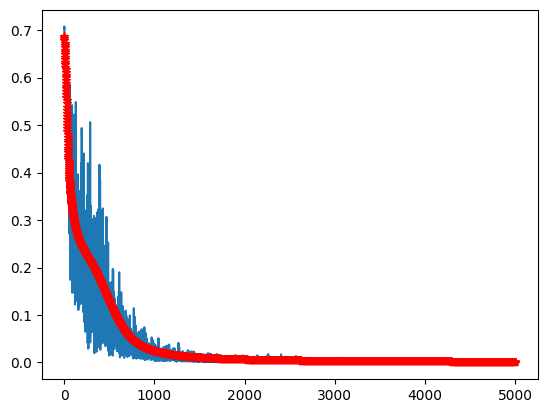

In [28]:
evaluate(model_mbgd, loss_tr, loss_te, test_dataloader, batch_size, epochs)

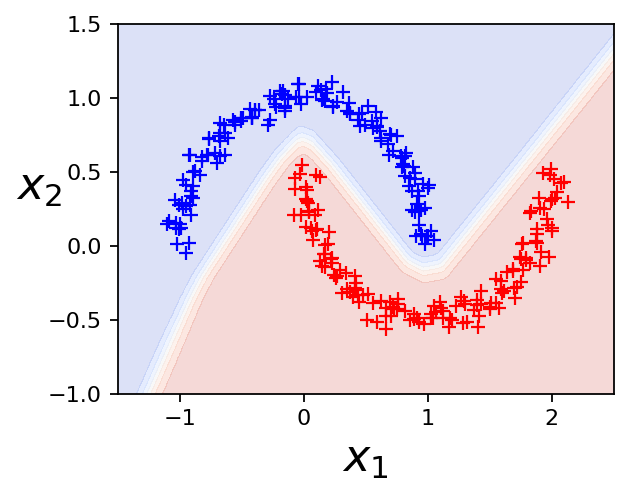

In [29]:
plot_predictions(X, y, model_mbgd, [-1.5, 2.5, -1, 1.5])